<a href="https://colab.research.google.com/github/mateusribeirocampos/diollm/blob/main/YOLOv3_Dec_seg_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Criação do diretório darknet para o modelo yolo a partir do repositório de Alexey AB.

In [2]:
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!make clean && make

Cloning into 'darknet'...
remote: Enumerating objects: 15873, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15873 (delta 12), reused 7 (delta 7), pack-reused 15850 (from 3)
Receiving objects: 100% (15873/15873), 14.50 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (10679/10679), done.
/content/darknet
rm -rf ./obj/image_opencv.o ./obj/http_stream.o ./obj/gemm.o ./obj/utils.o ./obj/dark_cuda.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/darknet.o ./obj/detection_layer.o ./obj/captcha.o ./obj/route_layer.o ./obj/writing.o ./obj/box.o ./obj/nightmare.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/coco.o ./obj/dice.o ./obj/yolo.

## Instalação da pacote lipopencv-dv e tree

 It's the development version of OpenCV (Open Source Computer Vision Library), a popular library used for computer vision tasks (like image processing, object detection, etc.). The development version includes header files and libraries needed to build applications that use OpenCV.

 o pacote tree facilita a visualização da estrutura do projeto

In [3]:
!apt-get install libopencv-dev
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (671 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This fronte

## Criação dos arquivos

Os arquivos vão receber as configurações e os database para o treino, validação e testes.

In [4]:
!mkdir -p /content/backup
!mkdir -p /content/coco/images

## Fazer o download

Aqui é feito o download do database todos compactados

In [5]:
# Baixar val2017 (1GB)
!wget -c http://images.cocodataset.org/zips/val2017.zip -P /content/coco/images

# Baixar test2017
!wget -c http://images.cocodataset.org/zips/test2017.zip -P /content/coco/images

# Baixar imagens de treino (18GB)
!wget -c http://images.cocodataset.org/zips/train2017.zip -P /content/coco/images

--2025-02-16 11:27:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.116.89, 52.217.82.36, 3.5.28.27, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.116.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/coco/images/val2017.zip’

val2017.zip         100%[===================>] 777.80M  41.7MB/s    in 20s     

2025-02-16 11:28:19 (39.3 MB/s) - ‘/content/coco/images/val2017.zip’ saved [815585330/815585330]

--2025-02-16 11:28:19--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.35.121, 54.231.228.41, 52.216.92.179, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.35.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘/content/coco/images/test2017.zip

## Descompactação do database

In [7]:
!mkdir -p /content/coco/annotations

# Baixar anotações (train + val)
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco/annotations

--2025-02-16 11:39:38--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.222.121, 52.216.210.129, 3.5.8.211, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.222.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco/annotations/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  43.6MB/s    in 6.2s    

2025-02-16 11:39:45 (38.8 MB/s) - ‘/content/coco/annotations/annotations_trainval2017.zip’ saved [252907541/252907541]



In [9]:
!ls /content/coco/annotations

annotations_trainval2017.zip


In [8]:
# Descompactar validações
!unzip /content/coco/images/val2017.zip -d /content/coco/images
!rm /content/coco/images/val2017.zip

# Descompactar imagens de testes
!unzip /content/coco/images/test2017.zip -d /content/coco/images
!rm /content/coco/images/test2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/images/test2017/000000251604.jpg  
 extracting: /content/coco/images/test2017/000000145034.jpg  
 extracting: /content/coco/images/test2017/000000234833.jpg  
 extracting: /content/coco/images/test2017/000000025927.jpg  
 extracting: /content/coco/images/test2017/000000393116.jpg  
 extracting: /content/coco/images/test2017/000000536478.jpg  
 extracting: /content/coco/images/test2017/000000365460.jpg  
 extracting: /content/coco/images/test2017/000000089887.jpg  
 extracting: /content/coco/images/test2017/000000274928.jpg  
 extracting: /content/coco/images/test2017/000000310028.jpg  
 extracting: /content/coco/images/test2017/000000229793.jpg  
 extracting: /content/coco/images/test2017/000000394339.jpg  
 extracting: /content/coco/images/test2017/000000564538.jpg  
 extracting: /content/coco/images/test2017/000000440585.jpg  
 extracting: /content/coco/images/test2017/000000541512.jpg  
 extracting: /conte

In [10]:
# Descompactar imagens
!unzip /content/coco/images/train2017.zip -d /content/coco/images
!rm /content/coco/images/train2017.zip

# Descompactar anotações de treino e validações
!unzip /content/coco/annotations/annotations_trainval2017.zip -d /content/coco/annotations
!rm /content/coco/annotations/annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/images/train2017/000000563584.jpg  
 extracting: /content/coco/images/train2017/000000276069.jpg  
 extracting: /content/coco/images/train2017/000000401194.jpg  
 extracting: /content/coco/images/train2017/000000502089.jpg  
 extracting: /content/coco/images/train2017/000000192183.jpg  
 extracting: /content/coco/images/train2017/000000425127.jpg  
 extracting: /content/coco/images/train2017/000000126766.jpg  
 extracting: /content/coco/images/train2017/000000324161.jpg  
 extracting: /content/coco/images/train2017/000000452746.jpg  
 extracting: /content/coco/images/train2017/000000423782.jpg  
 extracting: /content/coco/images/train2017/000000546343.jpg  
 extracting: /content/coco/images/train2017/000000249290.jpg  
 extracting: /content/coco/images/train2017/000000025529.jpg  
 extracting: /content/coco/images/train2017/000000316928.jpg  
 extracting: /content/coco/images/train2017/000000337866.jpg  
 ext

## Verificação dos arquivos annotations

In [11]:
!ls /content/coco/annotations/

annotations


In [12]:
# Mova todos os JSONs para /content/coco/annotations/
!mv /content/coco/annotations/annotations/*.json /content/coco/annotations/
!rm -rf /content/coco/annotations/annotations

In [13]:
!ls /content/coco/annotations/

captions_train2017.json  instances_train2017.json  person_keypoints_train2017.json
captions_val2017.json	 instances_val2017.json    person_keypoints_val2017.json


## Estrutura dos diretórios

In [14]:
!tree -d /content/coco/

/content/coco/
├── annotations
└── images
    ├── test2017
    ├── train2017
    └── val2017

5 directories


In [15]:
!tree -d /content/coco/images/

/content/coco/images/
├── test2017
├── train2017
└── val2017

3 directories


# Função de criação dos arquvivos para treino e validação.

In [41]:
import os
import shutil
from pycocotools.coco import COCO

def setup_coco_directories(base_dir: str, splits: list):
    """Cria a estrutura de diretórios para o dataset filtrado"""
    os.makedirs(base_dir, exist_ok=True)
    for split in splits:
        os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

def create_config_files(base_dir: str, categories: list):
    """Cria os arquivos de configuração obj.names e obj.data"""
    # obj.names
    with open(os.path.join(base_dir, 'obj.names'), 'w') as f:
        f.write('\n'.join(categories))

    # obj.data (corrigido indentação)
    config_content = f"""classes = {len(categories)}
train = {os.path.join(base_dir, 'train.txt')}
valid = {os.path.join(base_dir, 'val.txt')}
names = {os.path.join(base_dir, 'obj.names')}
backup = /content/backup
"""
    with open(os.path.join(base_dir, 'obj.data'), 'w') as f:
        f.write(config_content)

def generate_split_filelists(base_dir: str, splits: list):
    """Gera os arquivos train.txt e val.txt com caminhos absolutos"""
    for split in splits:
        if split == 'test': continue

        img_dir = os.path.join(base_dir, split, 'images')
        output_file = os.path.join(base_dir, f'{split}.txt')

        # Verifica se o diretório de imagens existe
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Diretório não encontrado: {img_dir}")

        with open(output_file, 'w') as f:
            for img_name in sorted(os.listdir(img_dir)):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    f.write(f"{img_dir}/{img_name}\n")

def process_coco_split(splits: list, categories: list, max_samples_per_split: int = None):
    """Processa splits do COCO convertendo para formato YOLO"""
    base_dir = '/content/coco/filtered'

    # 1. Criar estrutura de diretórios
    setup_coco_directories(base_dir, splits)

    # 2. Criar arquivos de configuração
    create_config_files(base_dir, categories)

    # 3. Processar cada split
    for split in splits:
        print(f"\nProcessando split: {split}")
        img_source_dir = f'/content/coco/images/{split}2017'
        img_dest_dir = os.path.join(base_dir, split, 'images')

        # Verificar origem das imagens
        if not os.path.exists(img_source_dir):
            raise FileNotFoundError(f"Diretório de origem não encontrado: {img_source_dir}")

        # Processar imagens
        if split == 'test':
            images = [{'file_name': f} for f in os.listdir(img_source_dir)]
        else:
            coco = COCO(f'/content/coco/annotations/instances_{split}2017.json')
            cat_ids = coco.getCatIds(catNms=categories)
            img_ids = coco.getImgIds(catIds=cat_ids)
            images = coco.loadImgs(img_ids[:max_samples_per_split] if max_samples_per_split else img_ids)

        # Limitar amostras
        if max_samples_per_split and split != 'test':
            images = images[:max_samples_per_split]

        # Copiar imagens
        for img in images:
            src = os.path.join(img_source_dir, img['file_name'])
            dst = os.path.join(img_dest_dir, img['file_name'])
            shutil.copy(src, dst)

        # Processar anotações para train/val
        if split != 'test':
            ann_dest_dir = os.path.join(base_dir, split, 'labels')
            os.makedirs(ann_dest_dir, exist_ok=True)

            coco = COCO(f'/content/coco/annotations/instances_{split}2017.json')

            for img in images:
                ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids)
                annotations = coco.loadAnns(ann_ids)

                label_path = os.path.join(ann_dest_dir, img['file_name'].replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    for ann in annotations:
                        x, y, w, h = ann['bbox']
                        img_w, img_h = img['width'], img['height']

                        # Conversão para formato YOLO
                        cx = (x + w/2) / img_w
                        cy = (y + h/2) / img_h
                        nw = w / img_w
                        nh = h / img_h

                        class_id = categories.index(coco.loadCats(ann['category_id'])[0]['name'])
                        f.write(f"{class_id} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}\n")

    # 4. Gerar listas de imagens após processamento
    generate_split_filelists(base_dir, splits)

    # 5. Validar estrutura
    print("\nValidação final:")
    !tree {base_dir} -L 2
    print("\nExemplo de arquivo train.txt:")
    !head -n 2 {os.path.join(base_dir, 'train.txt')}

# Execução
process_coco_split(
    splits=['train', 'val', 'test'],
    categories=['boat', 'person'],
    max_samples_per_split=500
)


Processando split: train
loading annotations into memory...
Done (t=17.65s)
creating index...
index created!
loading annotations into memory...
Done (t=19.29s)
creating index...
index created!

Processando split: val
loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!

Processando split: test

Validação final:
/content/coco/filtered
├── obj.data
├── obj.names
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── train.txt
├── val
│   ├── images
│   └── labels
└── val.txt

9 directories, 4 files

Exemplo de arquivo train.txt:
/content/coco/filtered/train/images/000000000882.jpg
/content/coco/filtered/train/images/000000001244.jpg


## Verificação dos diretórios de treino e validação

In [42]:
# Verifique se existem e contêm caminhos das imagens
!ls /content/coco/filtered/train.txt /content/coco/filtered/val.txt

# Exemplo do conteúdo de train.txt (primeiras 2 linhas)
!head -n 2 /content/coco/filtered/train.txt

/content/coco/filtered/train.txt  /content/coco/filtered/val.txt
/content/coco/filtered/train/images/000000000882.jpg
/content/coco/filtered/train/images/000000001244.jpg


In [43]:
!tree /content/coco/filtered -L 2

/content/coco/filtered
├── obj.data
├── obj.names
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── train.txt
├── val
│   ├── images
│   └── labels
└── val.txt

9 directories, 4 files


## Verificação de Integridade

In [44]:
def validate_dataset(base_dir: str, splits: list):
    """Valida se número de imagens e labels corresponde"""
    for split in splits:
        img_dir = os.path.join(base_dir, split, 'images')
        label_dir = os.path.join(base_dir, split, 'labels')

        num_images = len(os.listdir(img_dir))
        num_labels = len(os.listdir(label_dir)) if split != 'test' else print("OK")

        print(f"{split}: {num_images} imagens, {num_labels} labels")
        if split != 'test' and num_images != num_labels:
            raise ValueError("Inconsistência entre imagens e labels!")

## Controle de Versão dos Arquivos Gerados

In [45]:
def save_dataset_version(base_dir: str):
    """Salva metadados da versão do dataset"""
    version_info = {
        'created_at': datetime.now().isoformat(),
        'categories': ['boat', 'person'],
        'splits': ['train', 'val', 'test'],
        'num_samples': {split: len(os.listdir(os.path.join(base_dir, split, 'images')))
                       for split in ['train', 'val', 'test']}
    }

    with open(os.path.join(base_dir, 'version.json'), 'w') as f:
        json.dump(version_info, f, indent=2)

## Documentação

In [46]:
def generate_documentation(base_dir: str):
    """Cria arquivo README com informações do dataset"""
    readme_content = f"""# COCO Filtered Dataset

    ## Categories
    {', '.join(['boat', 'person'])}

    ## Splits
    {', '.join(['train', 'val', 'test'])}

    ## Statistics
    """
    for split in ['train', 'val', 'test']:
        num_images = len(os.listdir(os.path.join(base_dir, split, 'images')))
        readme_content += f"\n- {split}: {num_images} images"

    with open(os.path.join(base_dir, 'README.md'), 'w') as f:
        f.write(readme_content)

## Adição dos pesos para treino

In [29]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2025-02-16 12:00:28--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  16.9MB/s    in 14s     

2025-02-16 12:00:43 (16.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## Verificação do diretório onde os pesos foram salvos

In [30]:
!which yolov3.weights

## Verificação dos nomes

In [47]:
!cat /content/coco/filtered/obj.names

boat
person

## Verificação dos dados

In [32]:
!cat /content/coco/filtered/obj.data

classes = 2
train = /content/coco/filtered/train.txt
valid = /content/coco/filtered/val.txt
names = /content/coco/filtered/obj.names
backup = /content/backup


## Configuração dos arquvios para treino

In [33]:
# Cria cópia do cfg original
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

# Aplica modificações
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/yolov3_custom.cfg
!sed -i 's/classes=80/classes=2/' cfg/yolov3_custom.cfg
!sed -i 's/filters=255/filters=21/' cfg/yolov3_custom.cfg

## Execução dos testes

In [48]:
!./darknet detector train /content/coco/filtered/obj.data cfg/yolov3_custom.cfg yolov3.weights -dont_show -map

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, GPU count: 1  
 OpenCV version: 4.5.4
 Prepare additional network for mAP calculation...
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 -

In [35]:
!tree /content/coco/filtered/train -L 2

/content/coco/filtered/train
├── images
│   ├── 000000016773.jpg
│   ├── 000000024609.jpg
│   ├── 000000032818.jpg
│   ├── 000000032965.jpg
│   ├── 000000041199.jpg
│   ├── 000000041247.jpg
│   ├── 000000049165.jpg
│   ├── 000000049175.jpg
│   ├── 000000049402.jpg
│   ├── 000000065755.jpg
│   ├── 000000065894.jpg
│   ├── 000000073753.jpg
│   ├── 000000073826.jpg
│   ├── 000000073898.jpg
│   ├── 000000073976.jpg
│   ├── 000000090359.jpg
│   ├── 000000090476.jpg
│   ├── 000000098345.jpg
│   ├── 000000098601.jpg
│   ├── 000000098636.jpg
│   ├── 000000106755.jpg
│   ├── 000000106865.jpg
│   ├── 000000114732.jpg
│   ├── 000000114879.jpg
│   ├── 000000139440.jpg
│   ├── 000000155763.jpg
│   ├── 000000155885.jpg
│   ├── 000000163929.jpg
│   ├── 000000172196.jpg
│   ├── 000000172271.jpg
│   ├── 000000172369.jpg
│   ├── 000000180354.jpg
│   ├── 000000196672.jpg
│   ├── 000000204805.jpg
│   ├── 000000205035.jpg
│   ├── 000000213357.jpg
│   ├── 000000213381.jpg
│   ├── 000000229522.jpg
│   ├── 00

In [94]:
!nvidia-smi

Sun Feb 16 13:05:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [84]:
!mkdir -p imgFromWebTest
!wget -O imgFromWebTest/test_image.jpg https://img.freepik.com/free-photo/back-view-young-citizens-walking-street-with-phones_74855-4948.jpg?t=st=1739710472~exp=1739714072~hmac=592a6dc15dbb5e83e1469b1dadb5ba59c00f6b94c2410a15daffd3cf1b5397bf&w=1060/640/480

--2025-02-16 12:54:53--  https://img.freepik.com/free-photo/back-view-young-citizens-walking-street-with-phones_74855-4948.jpg?t=st=1739710472~exp=1739714072~hmac=592a6dc15dbb5e83e1469b1dadb5ba59c00f6b94c2410a15daffd3cf1b5397bf
Resolving img.freepik.com (img.freepik.com)... 96.16.53.162, 96.16.53.137, 2a02:26f0:1180:19::212:790b, ...
Connecting to img.freepik.com (img.freepik.com)|96.16.53.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87372 (85K) [image/jpeg]
Saving to: ‘imgFromWebTest/test_image.jpg’

imgFromWebTest/test 100%[===================>]  85.32K  --.-KB/s    in 0.06s   

2025-02-16 12:54:53 (1.28 MB/s) - ‘imgFromWebTest/test_image.jpg’ saved [87372/87372]



In [85]:
!find / -name "test_image.jpg" 2>/dev/null

/content/darknet/imgFromWebTest/test_image.jpg


In [74]:
!ls -lh predictions.jpg

ls: cannot access 'predictions.jpg': No such file or directory


In [93]:
!./darknet detector test /content/coco/filtered/obj.data cfg/yolov3_custom.cfg /content/backup/yolov3_custom_final.weights /content/darknet/imgFromWebTest/test_image.jpg -dont_show

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

In [92]:
!ls -l /content/backup/yolov3_custom_final.weights

-rw-r--r-- 1 root root 246326928 Feb 16 12:19 /content/backup/yolov3_custom_final.weights


In [87]:
!ls -lh /content/darknet/

total 242M
drwxr-xr-x 5 root root 4.0K Feb 16 11:25 3rdparty
drwxr-xr-x 2 root root 4.0K Feb 16 11:25 backup
-rw-r--r-- 1 root root 6.7K Feb 16 12:19 bad.list
drwxr-xr-x 3 root root 4.0K Feb 16 11:25 build
-rwxr-xr-x 1 root root  44K Feb 16 11:25 build.ps1
drwxr-xr-x 3 root root 4.0K Feb 16 12:01 cfg
drwxr-xr-x 3 root root 4.0K Feb 16 11:25 cmake
-rw-r--r-- 1 root root  30K Feb 16 11:25 CMakeLists.txt
-rwxr-xr-x 1 root root 4.8M Feb 16 11:27 darknet
-rw-r--r-- 1 root root 1.5K Feb 16 11:25 DarknetConfig.cmake.in
-rw-r--r-- 1 root root 9.4K Feb 16 11:25 darknet_images.py
-rw-r--r-- 1 root root  11K Feb 16 11:25 darknet.py
-rw-r--r-- 1 root root 7.9K Feb 16 11:25 darknet_video.py
drwxr-xr-x 3 root root 4.0K Feb 16 11:25 data
-rw-r--r-- 1 root root  366 Feb 16 11:25 docker-compose.yml
-rw-r--r-- 1 root root  774 Feb 16 11:25 Dockerfile.cpu
-rw-r--r-- 1 root root  834 Feb 16 11:25 Dockerfile.gpu
-rwxr-xr-x 1 root root  110 Feb 16 11:25 image_yolov3.sh
-rwxr-xr-x 1 root root  110 Feb 16 11:

Imagem carregada com sucesso.


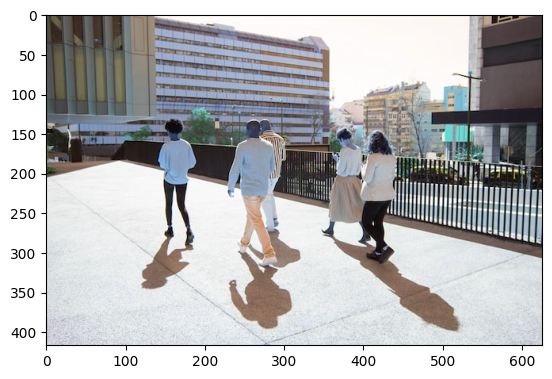

In [88]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread("/content/darknet/imgFromWebTest/test_image.jpg")
if image is None:
    print("Erro: Imagem não encontrada ou corrompida.")
else:
    image = cv2.imread("/content/darknet/imgFromWebTest/test_image.jpg")
    plt.imshow(image)
    print("Imagem carregada com sucesso.")


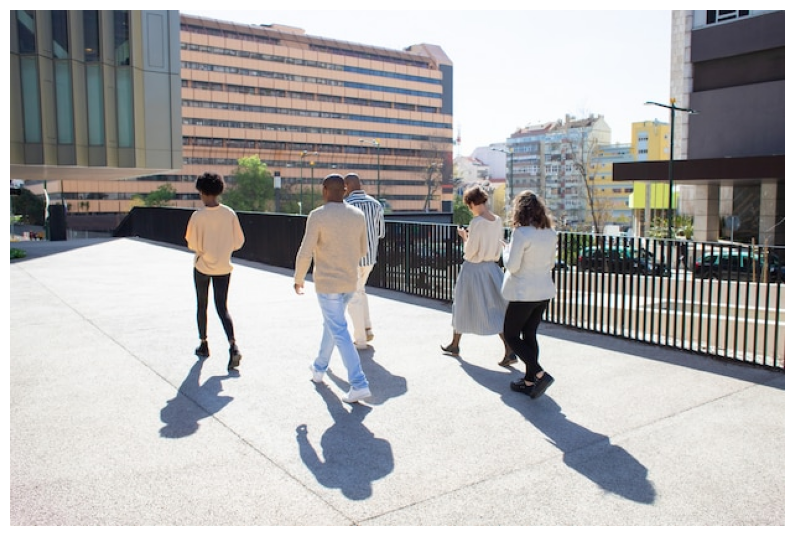

In [89]:
image = cv2.imread("/content/darknet/imgFromWebTest/test_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()